In [1]:
!pip install -qqq --upgrade torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html
!git clone https://github.com/patil-suraj/onnx_transformers.git
!pip install -U -qqq -e ./onnx_transformers

Cloning into 'onnx_transformers'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 105 (delta 48), reused 92 (delta 37), pack-reused 0
Receiving objects: 100% (105/105), 34.52 KiB | 415.00 KiB/s, done.
Resolving deltas: 100% (48/48), done.


In [2]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           AuthenticAMD
CPU family:          23
Model:               1
Model name:          AMD EPYC 7571
Stepping:            2
CPU MHz:             2541.395
BogoMIPS:            4399.98
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           64K
L2 cache:            512K
L3 cache:            8192K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid aperfmperf tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a m

Restart notebook after installation

In [1]:
from onnx_transformers import pipeline

In [2]:
# load onnx pipeline
nlp_onnx = pipeline("feature-extraction",  onnx=True)

/notebooks/onnx_tests/onnx_transformers/.onnx/distilbert-base-cased/distilbert-base-cased.onnx.input_names.json
Creating folder /notebooks/onnx_tests/onnx_transformers/.onnx/distilbert-base-cased
Using framework PyTorch: 1.6.0+cpu
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch', 1: 'sequence'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


/usr/local/lib/python3.7/dist-packages/transformers/modeling_utils.py:1570: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  input_tensor.shape == tensor_shape for input_tensor in input_tensors


Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch', 1: 'sequence'}


In [3]:
# load torch pipeline
nlp_torch = pipeline("feature-extraction", onnx=False)

In [4]:
from contextlib import contextmanager
from dataclasses import dataclass
from time import time
from tqdm import trange

@contextmanager
def track_infer_time(buffer: [int]):
    start = time()
    yield
    end = time()

    buffer.append(end - start)


@dataclass
class OnnxInferenceResult:
  model_inference_time: [int]  
  optimized_model_path: str

In [5]:
pipelines = [("Pytorch CPU", nlp_torch), ("ONNX CPU", nlp_onnx)]
results = {}
for label, pipeline_ in pipelines:
  # Compute 
  time_buffer = []
  for _ in trange(100, desc=f"Tracking inference time for {label}"):
    with track_infer_time(time_buffer):
      pipeline_("My name is BERT")

  # Store the result
  results[label] = OnnxInferenceResult(
      time_buffer, 
      None
  )

Tracking inference time for ONNX CPU: 100%|██████████| 100/100 [00:02<00:00, 37.85it/s]


In [6]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import os


def plot_benchmark(results):
    # Compute average inference time + std
    time_results = {k: np.mean(v.model_inference_time) * 1e3 for k, v in results.items()}
    time_results_std = np.std([v.model_inference_time for v in results.values()]) * 1000

    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_ylabel("Avg Inference time (ms)")
    ax.set_title("Average inference time (ms) for each provider")
    ax.bar(time_results.keys(), time_results.values(), yerr=time_results_std)
    plt.show()

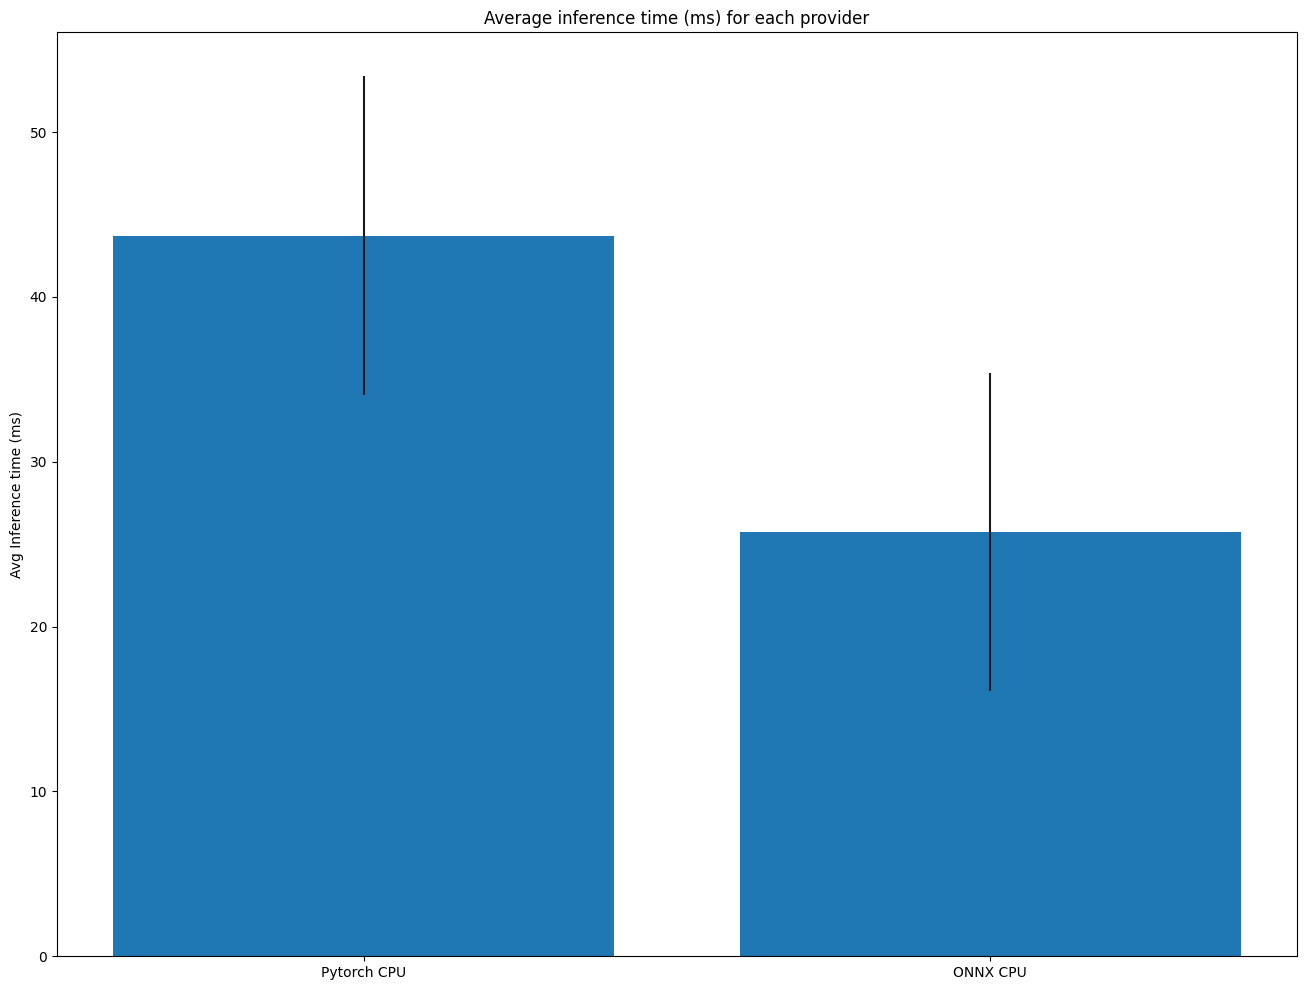

In [7]:
plot_benchmark(results)

Now, let's benchmark anothe pipline

In [8]:
# load onnx pipeline
nlp_onnx = pipeline("question-answering",  onnx=True)
# load torch pipeline
nlp_torch = pipeline("question-answering", onnx=False)

/notebooks/onnx_tests/onnx_transformers/.onnx/distilbert-base-cased-distilled-squad/distilbert-base-cased-distilled-squad.onnx.input_names.json


In [9]:
import warnings

Tracking inference time for ONNX CPU: 100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


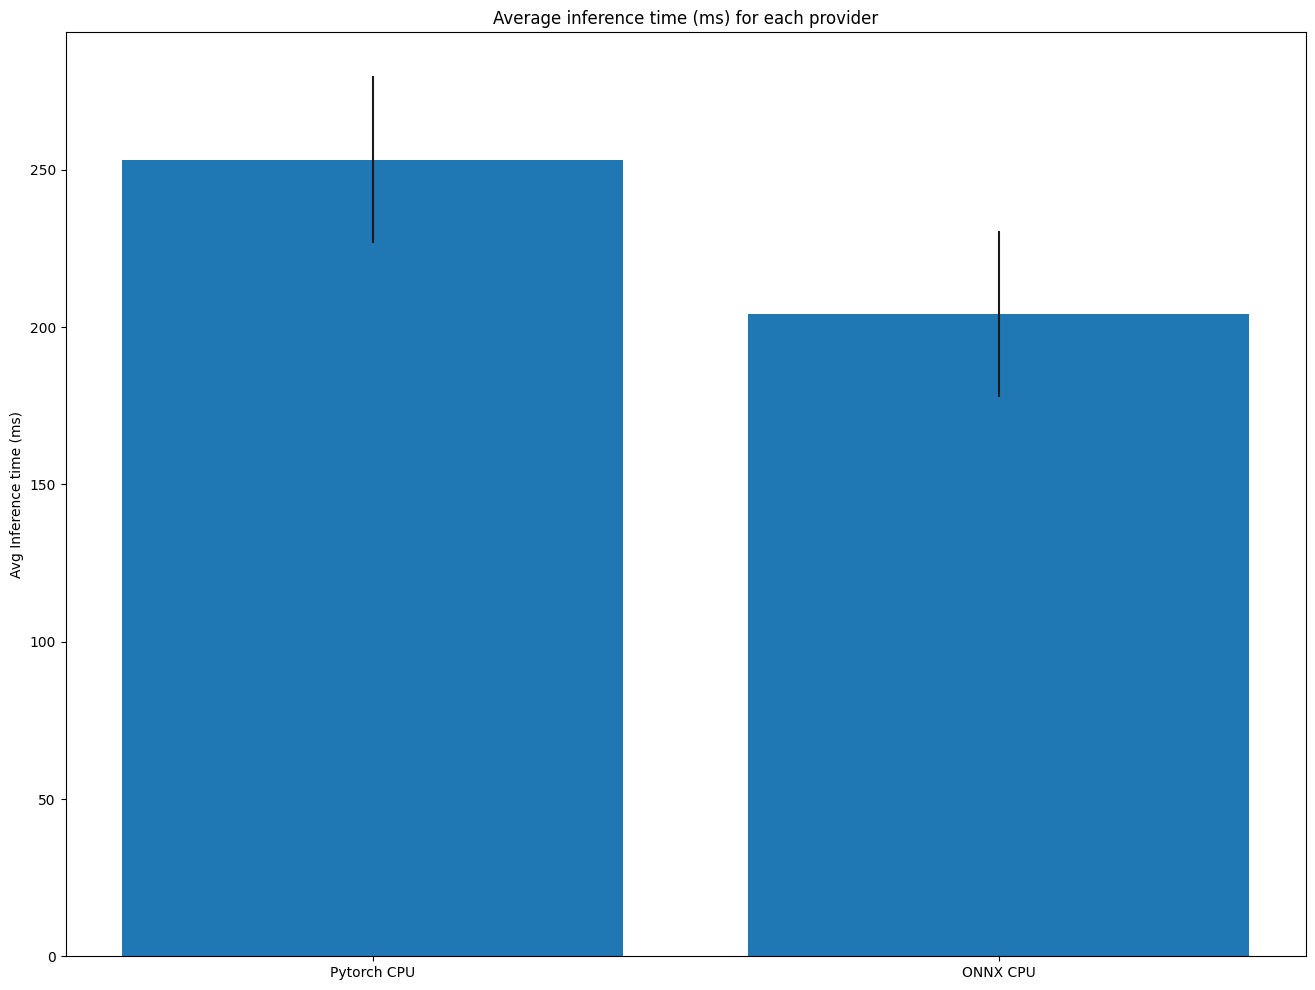

In [10]:
pipelines = [("Pytorch CPU", nlp_torch), ("ONNX CPU", nlp_onnx)]
results = {}
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for label, pipeline_ in pipelines:
      # Compute 
      time_buffer = []
      for _ in trange(100, desc=f"Tracking inference time for {label}"):
        with track_infer_time(time_buffer):
          pipeline_({"question": "What is ONNX runtime ?", "context": "ONNX Runtime is a highly performant single inference engine for multiple platforms and hardware"})

      # Store the result
      results[label] = OnnxInferenceResult(
          time_buffer, 
          None
      )

plot_benchmark(results)